NOMBRES: Diego Alberto

APELLIDOS: Leiva Pérez

CARNE: 21752

FECHA: 04/09/2025

## Librerias

In [1]:
import re
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

## Utilidades para Texto

In [2]:
def normalize_text(text: str) -> str:
    """
    Convierte a minúsculas, elimina puntuación y caracteres especiales,
    y normaliza espacios en blanco.
    Args:
        text (str): Texto a normalizar.
    Returns:
        str: Texto normalizado.
    """
    text = text.lower()
    # Conserva letras (incluye tildes/ñ), dígitos y espacios.
    text = re.sub(r"[^a-záéíóúüñ0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    """
    Tokeniza el texto normalizado en palabras.
    Args:
        text (str): Texto a tokenizar.
    Returns:
        list: Lista de tokens (palabras).
    """
    return normalize_text(text).split()

def build_vocab(tokenized_docs, min_freq: int = 1):
    """
    Construye el vocabulario a partir de documentos tokenizados.
    Args:
        tokenized_docs (list): Lista de documentos tokenizados.
        min_freq (int): Frecuencia mínima para incluir una palabra en el vocabulario.
    Returns:
        tuple: (vocabulario, word2idx, idx2word, counts)
    """
    counts = Counter([t for doc in tokenized_docs for t in doc])
    vocab = [w for w, c in counts.items() if c >= min_freq]
    vocab = sorted(vocab)
    word2idx = {w: i for i, w in enumerate(vocab)}
    idx2word = {i: w for i, w in enumerate(vocab)}
    return vocab, word2idx, idx2word, counts

def sliding_windows_indices(center, window_size, n):
    """
    Obtiene los índices de las palabras en una ventana deslizante alrededor de una palabra central.
    Args:
        center (int): Índice de la palabra central.
        window_size (int): Tamaño de la ventana (número de palabras a cada lado).
        n (int): Longitud total de la secuencia.
    Returns:
        list: Lista de índices en la ventana deslizante.
    """
    start = max(0, center - window_size)
    end = min(n, center + window_size + 1)
    return [i for i in range(start, end) if i != center]

## Ejercicio 1
Cree un corpus a su gusto como el visto en clase, cálcule PPMI, pero aplicando Lapace Smoothing.

In [3]:
corpus_docs = [
    # Abuelos/as y edad/actividad
    "el abuelo mayor juega ajedrez en la sala con la abuela mayor",
    "la abuela mayor cuida el jardin y hace jardineria con el abuelo mayor",
    # Padres y madres + actividades
    "el padre adulto repara autos en el taller y aprende mecanica",
    "la madre adulta estudia medicina y cuida la casa con paciencia",
    # Hijos/as + actividades/edad
    "el hijo joven practica skate en el parque despues de la escuela",
    "la hija joven pinta cuadros y aprende pintura en la escuela",
    # Tios/as + actividades/edad
    "el tio adulto sale a pesca y conversa en la sala",
    "la tia adulta baila danza y organiza reuniones en la casa",
    # Primos/as + actividades/edad
    "el primo joven juega videojuegos y estudia con el hijo joven",
    "la prima joven hace fotografia y practica pintura con la hija joven",
    # Sobrinos/as + edad
    "el sobrino niño visita la casa y lee cuentos en la sala",
    "la sobrina niña dibuja en el jardin y juega con la prima joven",
    # Conexiones cruzadas (refuerza co-ocurrencias)
    "el padre adulto conversa con el abuelo mayor en la sala",
    "la madre adulta camina con la abuela mayor en el jardin",
    "el tio adulto repara herramientas en el taller con el padre adulto",
    "la tia adulta organiza danza en la escuela y ayuda a la madre adulta",
    "el primo joven patina skate en el parque y habla con el sobrino niño",
    "la prima joven toma fotografia en el jardin y pinta con la hija joven",
    "el hijo joven visita la casa y estudia en la escuela con el primo joven",
    "la hija joven practica pintura en la sala y conversa con la sobrina niña",
]

# Preprocesamiento
tokenized_docs = [tokenize(d) for d in corpus_docs] # Lista de listas de tokens
vocab, word2idx, idx2word, counts = build_vocab(tokenized_docs, min_freq=1) # Vocabulario y mapeos

# Estadísticas básicas
print("Docs:", len(tokenized_docs)) # Número de documentos
print("Vocab size:", len(vocab)) # Tamaño del vocabulario 
print("Top-10 más frecuentes:", Counter([t for d in tokenized_docs for t in d]).most_common(10)) # Top-10 palabras más frecuentes

Docs: 20
Vocab size: 68
Top-10 más frecuentes: [('la', 30), ('el', 24), ('en', 16), ('y', 15), ('con', 13), ('joven', 13), ('mayor', 6), ('sala', 5), ('adulto', 5), ('adulta', 5)]


### Matriz de co-ocurrencias

In [4]:
def build_cooccurrence(tokenized_docs, word2idx, window_size=2):
    """
    Construye la matriz de co-ocurrencias a partir de documentos tokenizados.
    Args:
        tokenized_docs (list): Lista de documentos tokenizados.
        word2idx (dict): Mapeo de palabras a índices.
        window_size (int): Tamaño de la ventana deslizante.
    Returns:
        np.ndarray: Matriz de co-ocurrencias.
    """
    V = len(word2idx)
    M = np.zeros((V, V), dtype=float)
    for doc in tokenized_docs:
        n = len(doc)
        for i, w in enumerate(doc):
            wi = word2idx[w]
            for j in sliding_windows_indices(i, window_size, n):
                cj = word2idx[doc[j]]
                M[wi, cj] += 1.0
    return M

In [5]:
WINDOW = 2 # Tamaño de la ventana deslizante
C = build_cooccurrence(tokenized_docs, word2idx, window_size=WINDOW) # Matriz de co-ocurrencias
cooc_df= pd.DataFrame(C,index=vocab,columns=vocab)
cooc_df
cooc_df.iloc[:15,:15]

,a,abuela,abuelo,adulta,adulto,ajedrez,aprende,autos,ayuda,baila,camina,casa,con,conversa,cuadros
a,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
abuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
abuelo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
adulta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
adulto,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
ajedrez,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aprende,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
autos,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ayuda,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
baila,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PPMI con Laplace smoothing

In [6]:
def ppmi_laplace(C, alpha=1.0, eps=1e-12):
    """
    Calcula la matriz PPMI con suavizado de Laplace a partir de la matriz de co-ocurrencias.
    Args:
        C (np.ndarray): Matriz de co-ocurrencias.
        alpha (float): Parámetro de suavizado de Laplace.
        eps (float): Pequeña constante para evitar log(0).
    Returns:
        np.ndarray: Matriz PPMI.
    """
    C_s = C + alpha
    total = float(C_s.sum()) + eps
    Pwc = C_s / total
    Pw = Pwc.sum(axis=1, keepdims=True)
    Pc = Pwc.sum(axis=0, keepdims=True)
    PMI = np.log((Pwc + eps) / (Pw @ Pc + eps))
    return np.maximum(PMI, 0.0)

In [7]:
PPMI = ppmi_laplace(C, alpha=1.0)
ppmi_df = pd.DataFrame(PPMI, index=vocab, columns=vocab)
ppmi_df.iloc[:15,:15]

,a,abuela,abuelo,adulta,adulto,ajedrez,aprende,autos,ayuda,baila,camina,casa,con,conversa,cuadros
a,0.000000,0.00000,0.00000,0.000000,0.517657,0.002191,0.000000,0.002191,0.695338,0.002191,0.002191,0.000000,0.000000,0.000000,0.002191
abuela,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.572370,0.000000,0.000000
abuelo,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.572370,0.000000,0.000000
adulta,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.571724,0.571724,0.000000,0.069266,0.000000,0.000000
adulto,0.517657,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.571724,0.000000,0.000000,0.000000,0.000000,0.069266,0.466363,0.000000
ajedrez,0.002191,0.00000,0.00000,0.000000,0.000000,0.056258,0.015436,0.056258,0.056258,0.056258,0.056258,0.000000,0.000000,0.000000,0.056258
aprende,0.000000,0.00000,0.00000,0.000000,0.000000,0.015436,0.000000,0.015436,0.015436,0.015436,0.015436,0.000000,0.000000,0.000000,0.708583
autos,0.002191,0.00000,0.00000,0.000000,0.571724,0.056258,0.015436,0.056258,0.056258,0.056258,0.056258,0.000000,0.000000,0.000000,0.056258
ayuda,0.695338,0.00000,0.00000,0.000000,0.000000,0.056258,0.015436,0.056258,0.056258,0.056258,0.056258,0.000000,0.000000,0.000000,0.056258
baila,0.002191,0.00000,0.00000,0.571724,0.000000,0.056258,0.015436,0.056258,0.056258,0.056258,0.056258,0.000000,0.000000,0.000000,0.056258


### Similitud coseno y vecinos

In [8]:
def cosine_similarity_matrix(X):
    """
    Calcula la matriz de similitud coseno entre vectores.
    Args:
        X (np.ndarray): Matriz de vectores (filas).
    Returns:
        np.ndarray: Matriz de similitud coseno.
    """
    norms = np.linalg.norm(X, axis=1, keepdims=True) + 1e-12
    Xn = X / norms
    return Xn @ Xn.T

def top_k_neighbors(word, vocab, simM, k=5):
    """
    Obtiene los k vecinos más similares a una palabra dada usando la matriz de similitud.
    Args:
        word (str): Palabra objetivo.
        vocab (list): Lista de palabras en el vocabulario.
        simM (np.ndarray): Matriz de similitud coseno.
        k (int): Número de vecinos a retornar.
    Returns:
        list: Lista de tuplas (palabra, similitud) de los k vecinos más similares.
    """
    if word not in vocab:
        return []
    i = vocab.index(word)
    row = simM[i].copy()
    row[i] = -np.inf
    idxs = np.argsort(-row)[:k]
    return [(vocab[j], float(row[j])) for j in idxs]

In [9]:
S = cosine_similarity_matrix(PPMI) # Matriz de similitud coseno
sim_df = pd.DataFrame(S, index=vocab, columns=vocab)

targets = ["abuelo", "abuela", "padre", "madre", "hijo", "hija", "tio", "tia", "primo", "prima"]
# Iterar sobre algunas palabras de interés y mostrar sus vecinos más cercanos
for t in targets:
    print(f"\nVecinos de '{t}': ")
    for w,s in top_k_neighbors(t,vocab,S,k=5):
        print(f" {w:>12}\t{s:.3f}")


Vecinos de 'abuelo': 
      ajedrez	0.711
       abuela	0.698
        primo	0.384
           el	0.371
       taller	0.356

Vecinos de 'abuela': 
       abuelo	0.698
      ajedrez	0.465
           el	0.379
           la	0.310
         casa	0.304

Vecinos de 'padre': 
          tio	0.789
        autos	0.745
 herramientas	0.745
       repara	0.397
       adulto	0.397

Vecinos de 'madre': 
     medicina	0.553
          tia	0.552
       camina	0.437
        danza	0.412
        baila	0.352

Vecinos de 'hijo': 
        skate	0.665
        primo	0.650
         hija	0.610
   fotografia	0.516
        prima	0.441

Vecinos de 'hija': 
        prima	0.659
         hijo	0.610
      pintura	0.518
        skate	0.498
   fotografia	0.495

Vecinos de 'tio': 
        autos	0.807
 herramientas	0.807
        padre	0.789
            a	0.465
       adulto	0.437

Vecinos de 'tia': 
        danza	0.941
        madre	0.552
    reuniones	0.492
       camina	0.459
     medicina	0.384

Vecinos de 'primo': 
      

### Embeddings con SVD

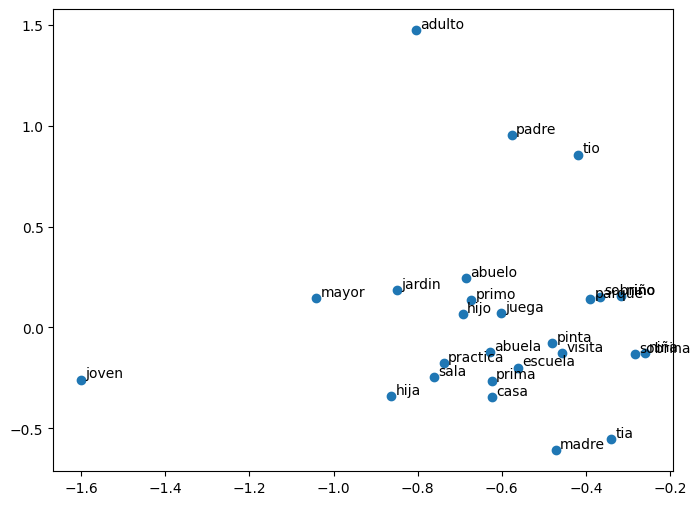

In [10]:
U, s, Vt = np.linalg.svd(PPMI, full_matrices=False)
X2D= U[:,:2]* s[:2]  # Proyección 2D
K = min(50, U.shape[1])   # #dims
E = U[:, :K] * s[:K] # Embeddings

words_to_plot = [
    "abuelo", "abuela", "padre", "madre", "hijo", "hija",
    "tio", "tia", "primo", "prima", "sobrino", "sobrina",
    "niño", "niña", "joven", "adulto", "mayor",
    "juega", "pinta", "practica", "visita",
    "casa", "sala", "jardin", "parque", "escuela"
]

# Filtrar coordenadas y etiquetas para las palabras a graficar
mask = [ w in words_to_plot for w in vocab]
coords = X2D[mask]
labels = [w for w in vocab if w in words_to_plot]

# Graficar
plt.figure(figsize=(8,6))
plt.scatter(coords[:,0],coords[:,1])
for (x,y),lab in zip(coords,labels):
  plt.text(x+0.01,y+0.01,lab)
plt.show()

## Ejercicio 2

Crear 10 analigias validas basadas en su texto, tome en cuenta que es necesario utilizar el codigo visto en clase y ajuste su corpus para poder lograr obtener todas las analogias

In [11]:
Ufull, sfull,Vtfull= np.linalg.svd(PPMI,full_matrices=False)

K=min(50,Ufull.shape[1])
E = Ufull[:,:K] * sfull[:K]

In [12]:
def word_vec(word, vocab=vocab, E=E):
    """
    Obtiene el vector de embedding para una palabra dada.
    Args:
        word (str): Palabra objetivo.
        vocab (list): Lista de palabras en el vocabulario.
        E (np.ndarray): Matriz de embeddings.
    Returns:
        np.ndarray or None: Vector de embedding o None si la palabra no está en el vocabulario.
    """
    if word not in vocab:
        return None
    return E[vocab.index(word)]

def most_similar(vec, E=E, topn=5, exclude_idx=None):
    """
    Encuentra las palabras más similares a un vector dado usando similitud coseno.
    Args:
        vec (np.ndarray): Vector objetivo.
        E (np.ndarray): Matriz de embeddings.
        topn (int): Número de palabras similares a retornar.
        exclude_idx (int or None): Índice a excluir de los resultados (por ejemplo, la palabra misma).
    Returns:
        tuple: (índices de palabras similares, similitudes)
    """
    norms = np.linalg.norm(E, axis=1, keepdims=True) + 1e-12
    En = E / norms
    vn = vec / (np.linalg.norm(vec) + 1e-12)
    sims = En @ vn
    if exclude_idx is not None:
        sims[exclude_idx] = -np.inf
    idxs = np.argsort(-sims)[:topn]
    return idxs, sims[idxs]

def analogy(a, b, c, vocab=vocab, E=E, topn=5):
    """
    Resuelve analogías del tipo "a es a b como c es a ?".
    Args:
        a (str): Primera palabra de la analogía.
        b (str): Segunda palabra de la analogía.
        c (str): Tercera palabra de la analogía.
        vocab (list): Lista de palabras en el vocabulario.
        E (np.ndarray): Matriz de embeddings.
        topn (int): Número de resultados a retornar.
    Returns:
        list: Lista de tuplas (palabra, similitud) de las palabras que completan la analogía.
    """
    va, vb, vc = word_vec(a, vocab, E), word_vec(b, vocab, E), word_vec(c, vocab, E)
    if va is None or vb is None or vc is None:
        return []
    target = vb - va + vc
    idxs, sims = most_similar(target, E=E, topn=topn + 3)
    results = []
    forbids = {vocab.index(w) for w in [a, b, c] if w in vocab}
    for idx, score in zip(idxs, sims):
        if idx not in forbids:
            results.append((vocab[idx], float(score)))
        if len(results) == topn:
            break
    return results

def softmax(x):
    """
    Calcula la función softmax de un vector.
    Args:
        x (list or np.ndarray): Vector de entrada.
    Returns:
        np.ndarray: Vector softmax.
    """
    x = np.array(x, dtype=float)
    x = x - np.max(x)           # estabilidad numérica
    ex = np.exp(x)
    return ex / (ex.sum() + 1e-12)

### Analogías

In [13]:
tests = [
    # Género (parejas familiares)
    ("abuelo", "abuela", "padre", "madre"),
    ("padre", "madre", "hijo", "hija"),
    ("tio", "tia", "sobrino", "sobrina"),
    ("primo", "prima", "hijo", "hija"),
    # Edades (mayor/adulto/joven/niño)
    ("abuelo", "mayor", "sobrino", "niño"),
    ("hijo", "joven", "hija", "joven"),  # mapea a atributo compartido
    # Actividades (relaciones persona-actividad)
    ("padre", "mecanica", "hijo", "skate"),
    ("abuela", "jardineria", "hija", "pintura"),
    ("tio", "pesca", "primo", "videojuegos"),
    ("tia", "danza", "prima", "fotografia"),
]

rows = []
for a, b, c, expected in tests:
    preds = analogy(a, b, c, topn=5)
    top3 = preds[:3]

    # calcular probs softmax sobre los 3 scores
    scores = [s for _, s in top3]
    probs = softmax(scores)

    # formatear como "palabra:prob"
    top3_fmt = [f"{w}: {p:.2f}" for (w, _), p in zip(top3, probs)]

    # ver si esperado aparece en top3
    rank = next((i for i, (w, _) in enumerate(top3) if w == expected), None) 

    rows.append({
        "analogia": f"{a}:{b} => {c}:?",
        "esperado": expected,
        "top3": " | ".join(top3_fmt),
        "acierto": rank is not None,
        "posicion": (rank + 1 if rank is not None else None)
    })

df_analogias = pd.DataFrame(rows)
print("\n==== RESULTADOS DE ANALOGÍAS (top-3) ====\n")
display(df_analogias)


==== RESULTADOS DE ANALOGÍAS (top-3) ====



,analogia,esperado,top3,acierto,posicion
0,abuelo:abuela => padre:?,madre,herramientas: 0.34 | autos: 0.34 | tio: 0.32,False,NaN
1,padre:madre => hijo:?,hija,hija: 0.35 | tia: 0.33 | medicina: 0.33,True,1.0
2,tio:tia => sobrino:?,sobrina,danza: 0.38 | reuniones: 0.31 | madre: 0.30,False,NaN
3,primo:prima => hijo:?,hija,fotografia: 0.39 | hija: 0.34 | pintura: 0.28,True,2.0
4,abuelo:mayor => sobrino:?,niño,con: 0.38 | casa: 0.32 | visita: 0.30,False,NaN
5,hijo:joven => hija:?,joven,con: 0.36 | practica: 0.33 | toma: 0.31,False,NaN
6,padre:mecanica => hijo:?,skate,cuadros: 0.34 | pintura: 0.34 | fotografia: 0.33,False,NaN
7,abuela:jardineria => hija:?,pintura,fotografia: 0.35 | prima: 0.34 | hijo: 0.31,False,NaN
8,tio:pesca => primo:?,videojuegos,skate: 0.36 | videojuegos: 0.33 | hijo: 0.32,True,2.0
9,tia:danza => prima:?,fotografia,fotografia: 0.40 | hija: 0.31 | jardineria: 0.28,True,1.0
